# DSPIN Tutorial (Gene DSPIN) v0

In [3]:
import numpy as np
from tqdm import tqdm
import anndata as ad
import sys
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.io import savemat, loadmat
import os
import pandas as pd

**Please make sure the current path is parallel with the folder "util"** 

Use other ways to import DSPIN class otherwise.

In [4]:
sys.path.append("..")
from util.dspin_abstract import DSPIN
import util.plot as plot

/Users/ygong/git/DSPIN-abstract/test/../util/compute.py:374: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


## Data Exploration

### Load Data
Preprocessing Should be Done Before Using DSPIN

In [5]:
data_folder = '../data/HSC_simulation'
save_path = '../test/test/HSC_simulation'

In [6]:
cadata = ad.read_h5ad(data_folder + '/hsc_simulation_with_perturbations.h5ad')

In [7]:
cadata

AnnData object with n_obs × n_vars = 13000 × 11
    obs: 'cell', 'sample_id'
    var: 'gene'

Notice that it is a small dataset with 10 genes, so we will use Gene-DSPIN later.

In [8]:
cadata.var

,gene
0,Cebpa
1,EgrNab
2,Eklf
3,Fli1
4,Fog1
5,Gata1
6,Gata2
7,Gfi1
8,Pu1
9,Scl


In [9]:
gene_list = cadata.var['gene'].values
num_gene = len(gene_list)
samp_list = np.unique(cadata.obs['sample_id'])
aux_ind = [- 1, 0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 3, 4, 5, 6, 7, 8, 9]
samp_name = ['CONTROL'] + [gene + '\nknock-down' for gene in gene_list] + [gene + '\nactivation' for gene in gene_list]
samp_list_name = [samp_name[aux_ind[ii] + 1] for ii in range(num_gene * 2 + 1)]

## Initialize a DSPIN Object

When a DSPIN instance is initialized, based on the comparison between the number of spin and the 
number of genes of the anndata, it automatically initiates a GeneDSPIN or a ProgramDSPIN. In the following example, a GeneDSPIN is iniatialized. The major difference between GeneDSPIN and ProgramDSPIN is that the later requires ONMF to cluster gene programs.

In [10]:
num_spin = cadata.shape[1] # num of gene
model = DSPIN(cadata, save_path, num_spin=num_spin)

11 genes have expression in more than 0.02 of the cells
GeneDSPIN initialized.


## Network Inference
Please set sample_col_name be the column name for sample id

An example list (optional) is a subset of all sample ids.

In [11]:
model.network_infer(sample_col_name='sample_id')

Using maximum_likelihood for network inference.
Progress: 5, Network gradient: 49.242222
Progress: 10, Network gradient: 22.302982
Progress: 15, Network gradient: 8.111818
Progress: 20, Network gradient: 8.414078
Progress: 25, Network gradient: 4.164314
Progress: 30, Network gradient: 2.405305
Progress: 35, Network gradient: 1.842833
Progress: 40, Network gradient: 0.998465
Progress: 45, Network gradient: 0.743913
Progress: 50, Network gradient: 0.517538
Progress: 55, Network gradient: 0.293857
Progress: 60, Network gradient: 0.177376
Progress: 65, Network gradient: 0.138801
Progress: 70, Network gradient: 0.098551
Progress: 75, Network gradient: 0.072917
Progress: 80, Network gradient: 0.050099
Progress: 85, Network gradient: 0.036122
Progress: 90, Network gradient: 0.027845
Progress: 95, Network gradient: 0.020430
Progress: 100, Network gradient: 0.014974


## Network Plotting

In [12]:
gene_program_csv = model.gene_program_csv

AttributeError: 'GeneDSPIN' object has no attribute 'gene_program_csv'

The names for gene programs can be set by the user.
Otherwise, users can call function "temporary_spin_name" in plot.py to create names for gene programs
from the first five genes in each program.

In [20]:
gene_list = cadata.var['gene']

In [13]:
cur_j = model.network 

In [30]:
sys.path.append("..")
from importlib import reload
import util.plot
reload(util.plot)
from util.plot import plot_final

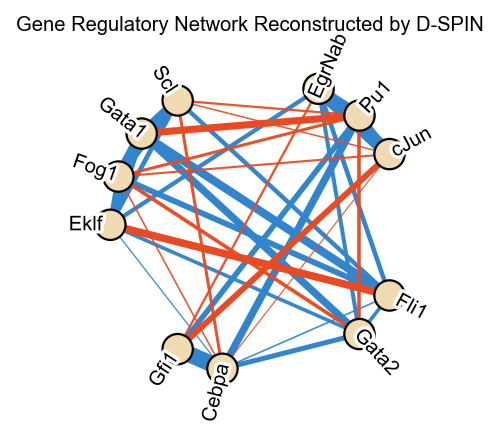

In [33]:
plot.plot_final(gene_program_name=gene_list, 
                cur_j=cur_j,
                figsize=[5, 3])

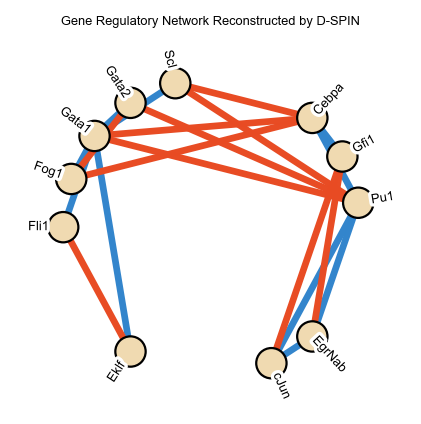

In [32]:
plot.plot_final(gene_program_name=gene_list, 
                cur_j=j_ref,
                figsize=[3.2, 3])

## Compare the inferred network with the ground truth

In [28]:
import re

ref_network = pd.read_csv(data_folder + '/refNetwork.csv')

gene_list = cadata.var['gene']
j_mat = np.zeros([len(gene_list), len(gene_list)])

for row in ref_network.itertuples():
    gene1 = row.Gene1
    gene2 = row.Gene2
    interaction = row.Type
    if interaction == '+':
        j_mat[gene_list == gene1, gene_list == gene2] = 1
    elif interaction == '-':
        j_mat[gene_list == gene1, gene_list == gene2] = -1

j_mat[(j_mat == - 1) & (j_mat.T == 1)] = 1
j_mat += j_mat.T
j_mat = np.sign(j_mat)

j_ref = j_mat.copy()

In [27]:
import networkx as nx
import matplotlib.patheffects as patheffects

def plot_jmat_network():

    self_loops = [(u, v) for u, v in G.edges() if u == v]
    G.remove_edges_from(self_loops)

    eposi= [(u, v) for (u,v,d) in G.edges(data=True) if d['weight'] > 0]
    wposi= np.array([d['weight'] for (u,v,d) in G.edges(data=True) if d['weight'] > 0])

    enega = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] < 0]
    wnega = np.array([d['weight'] for (u,v,d) in G.edges(data=True) if d['weight'] < 0])

    col1 = '#f0dab1'
    # nx.draw_networkx_nodes(G, pos, ax=ax, node_size=61.8 * nodesz, node_color=col1, edgecolors='None')
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=61.8 * nodesz, node_color=node_color, edgecolors='k')

    sig_fun = lambda xx : (1 / (1 + np.exp(- 5 * (xx + cc))))
    cc = np.max(np.abs(j_mat)) / 10
    # edges
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=eposi, width=linewz * wposi,
                            edge_color='#3285CC', alpha=sig_fun(wposi))

    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=enega, width=- linewz * wnega,
                            edge_color='#E84B23', alpha=sig_fun(- wnega))

    margin = 0.2
    plt.margins(x=0.1, y=0.1)

    ax.set_axis_off()
    ax.set_aspect('equal')
    return ax

Text(0.5, 1.0, 'D-SPIN')

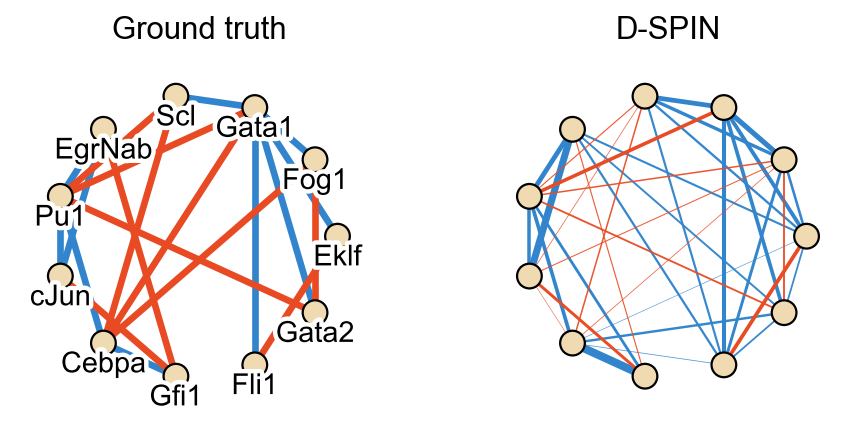

In [32]:
sc.set_figure_params(figsize=[3.2, 3])

spin_order = np.array([2, 4, 5, 9, 1, 8, 10, 0, 7, 3, 6])

nodesz = 2
linewz = 1.5
node_color = ['#f0dab1'] * num_spin
node_label = np.array(list(gene_list[spin_order]))

fig, grid = sc.pl._tools._panel_grid(0.1, 0.1, ncols=2, num_panels=2)

G = nx.from_numpy_array(j_ref[spin_order, :][:, spin_order] * 2)
pos = nx.circular_layout(G)

ax = plt.subplot(grid[0])
ax = plot_jmat_network()

path_effect = [patheffects.withStroke(linewidth=4, foreground='w')]
for ii in range(num_spin):
    text = plt.text(pos[ii][0], pos[ii][1] - 0.15, node_label[ii], fontsize=13, color='k', ha='center', va='center')
    text.set_path_effects(path_effect)
ax.set_title('Ground truth')


ax = plt.subplot(grid[1])
cur_j_filt = cur_j.copy()
cur_j_filt[np.abs(cur_j_filt) < np.percentile(np.abs(cur_j_filt), 40)] = 0
G = nx.from_numpy_array(cur_j_filt[spin_order, :][:, spin_order])
ax = plot_jmat_network()
ax.set_title('D-SPIN')

## Compute accuracy of the inferred network

In [33]:
def precision_recall_curve(j_ref, cur_j):
    num_spin = j_ref.shape[0]
    max_k = int(num_spin * (num_spin - 1) / 2)

    j_ref = np.triu(j_ref, k=1)
    cur_j = np.maximum(np.abs(cur_j), np.abs(cur_j).T)
    cur_j = np.triu(cur_j, k=1)

    # Flatten and sort the upper triangular portions of the matrices
    ref_indices = np.argsort(np.abs(j_ref), axis=None)[::-1]
    cur_indices = np.argsort(np.abs(cur_j), axis=None)[::-1]

    ref_values = np.sort(np.abs(j_ref), axis=None)[::-1]
    cur_values = np.sort(np.abs(cur_j), axis=None)[::-1]

    ref_indices = ref_indices[ref_values > 0]
    cur_indices = cur_indices[cur_values > 0]

    # Compute whether each inferred edge is in the list by order
    edge_in_list = np.isin(cur_indices, ref_indices)
    correct_predictions_cumsum = np.cumsum(edge_in_list)

    precision_values = correct_predictions_cumsum / np.arange(1, max_k+1)
    recall_values = correct_predictions_cumsum / len(ref_indices)

    return precision_values, recall_values

In [34]:
precision, recall = precision_recall_curve(j_ref, cur_j)
print('Top 10 accuracy %.2f , Top 15 accuracy %.2f, Top 20 accuracy %.2f' % (precision[9], precision[14], precision[19]))

Top 10 accuracy 1.00 , Top 15 accuracy 0.87, Top 20 accuracy 0.65
